Importing Usefull libraries

In [363]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

Importing The FashionMNIST Dataset

In [364]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_dataset = FashionMNIST(root='data/', train=False, transform=ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.6MB/s]


In [365]:
len(dataset)

60000

Splitting The Data into Validation and Train

In [366]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [367]:
batch_size=128



Loading The Data through DataLoader

In [368]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


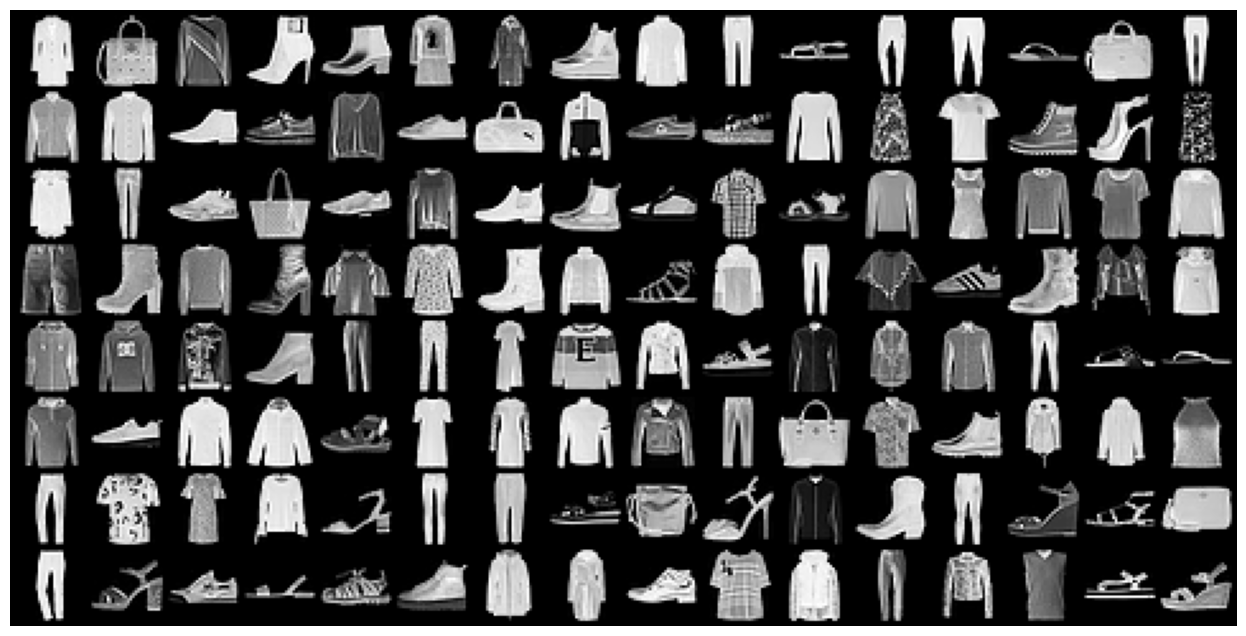

In [369]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

images.shape: torch.Size([128, 1, 28, 28])


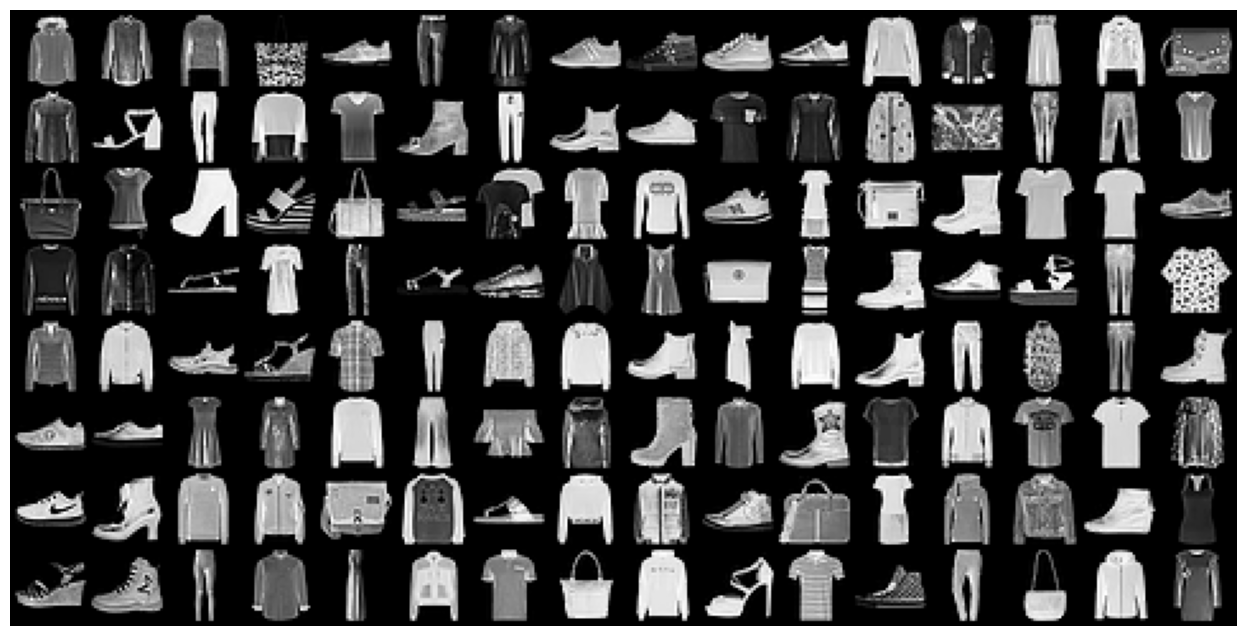

In [370]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [371]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Defining A Class With 4 Hidden Layers and Required Functions

In [372]:
class ImageClassification(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 2048)
        self.linear2 = nn.Linear(2048, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.linear4 = nn.Linear(512, 256)
        # Output layer
        self.linear5 = nn.Linear(256, out_size)


    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)  # (batch, 3*32*32)

        # Hidden layer 1 + activation + dropout
        out = F.relu(self.linear1(out))


        # Hidden layer 2 + activation + dropout
        out = F.relu(self.linear2(out))


        # Hidden layer 3 + activation + dropout
        out = F.relu(self.linear3(out))


        # Hidden layer 4 + activation + dropout
        out = F.relu(self.linear4(out))


        # Output layer (logits)
        out = self.linear5(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

Moving All the data to gpu to be more efficient

In [373]:
torch.cuda.is_available()

True

In [374]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [375]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [376]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Defining the methods to evaluate and fit(perform gradiet descent)

In [377]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [378]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)


In [379]:
input_size = 784
num_classes = 10

Making the model to be able to work on a GPU

In [380]:
device = torch.device('cuda')
model = ImageClassification(input_size, out_size=num_classes)
to_device(model, device)

ImageClassification(
  (linear1): Linear(in_features=784, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=10, bias=True)
)

In [381]:
model = to_device(model, device)
val_loader = DeviceDataLoader(val_loader, device)


In [382]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3024394512176514, 'val_acc': 0.09765625}]

Fitting the method and keeping track of it validation accuracy by using a list(History)

In [383]:
history += fit(5, 0.0005, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4089, val_acc: 0.8521
Epoch [1], val_loss: 0.3742, val_acc: 0.8635
Epoch [2], val_loss: 0.3485, val_acc: 0.8716
Epoch [3], val_loss: 0.3417, val_acc: 0.8734
Epoch [4], val_loss: 0.3459, val_acc: 0.8740


In [384]:
history += fit(5, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2978, val_acc: 0.8911
Epoch [1], val_loss: 0.2977, val_acc: 0.8917
Epoch [2], val_loss: 0.2908, val_acc: 0.8946
Epoch [3], val_loss: 0.2919, val_acc: 0.8988
Epoch [4], val_loss: 0.3003, val_acc: 0.8967


In [385]:
history += fit(5, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3013, val_acc: 0.8981
Epoch [1], val_loss: 0.2972, val_acc: 0.8994
Epoch [2], val_loss: 0.3049, val_acc: 0.8999
Epoch [3], val_loss: 0.3242, val_acc: 0.8912
Epoch [4], val_loss: 0.3195, val_acc: 0.8992


In [388]:
history += fit(5, 0.00001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4043, val_acc: 0.9055
Epoch [1], val_loss: 0.4132, val_acc: 0.9065
Epoch [2], val_loss: 0.4312, val_acc: 0.9055
Epoch [3], val_loss: 0.4374, val_acc: 0.9065
Epoch [4], val_loss: 0.4512, val_acc: 0.9069


As you can see with total of 20 epochs we have achieved 90 percent accuracy which is great

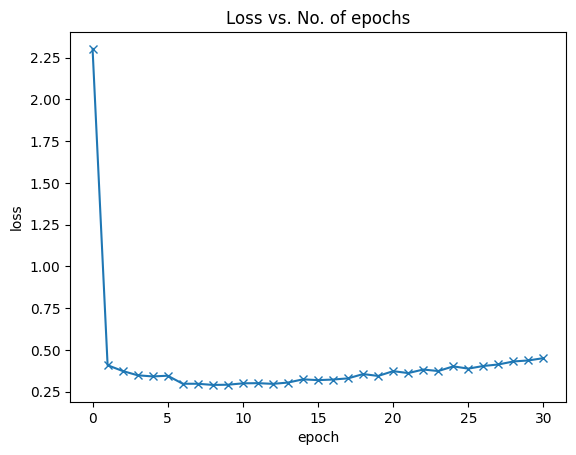

In [389]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

Making Prediction on test dataset

In [390]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: Ankle boot , Predicted: Ankle boot


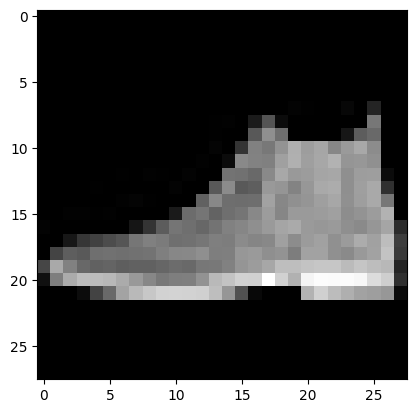

In [391]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Label: Shirt , Predicted: Shirt


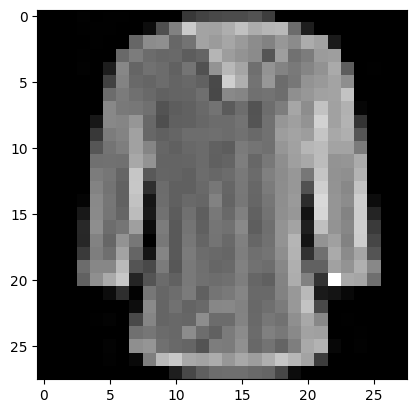

In [396]:
img, label = test_dataset[4]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])